# Riduzione della Dimensionalità

## Apprendimento Automatico | LM in Data Science

##      

da *Python Machine Learning* - Code Examples | Ch. 5 e documentazione scikit-learn

In [1]:
#from IPython.display import Image
%matplotlib inline

### Preprocessing

In [2]:
import pandas as pd
import numpy as np

df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', 
                      header=None)

# df_wine = pd.read_csv('wine.data', header=None)

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 
                   'Magnesium', 'Total phenols', 'Flavanoids', 
                   'Nonflavanoid phenols', 'Proanthocyanins', 'Color intensity', 'Hue', 
                   'OD280/OD315 of diluted wines', 'Proline']

df_wine.head()

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


Suddivisione dei dati in *training* e *test set* (70% - 30%):

In [3]:
from sklearn.model_selection import train_test_split

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.3, 
                     stratify=y,
                     random_state=0)

Standardizzazione dei dati:

In [4]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train) # E NON X_test_std = sc.fit_transform(X_test)
X_test_std = sc.transform(X_test)

**NOTA** *errore tipico*

* `X_test_std = sc.fit_transform(X_test)` invece di `X_test_std = sc.transform(X_test)`<br> non comporta grandi differenze in questo caso particolare,<br> tuttavia _in generale_ si dovrebbero usare per il test set <u>gli stessi</u> parametri stimati per il training set
    +  i _nuovi dati_ del test set <u>non</u> vanno standardizzati separatamente

## Algoritmi Sequenziali di *Feature Selection*

In [5]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)

# selezione delle feature
#sbs = SBS(knn, k_features=1)
sfs = SequentialFeatureSelector(knn, n_features_to_select=3)

#sbs.fit(X_train_std, y_train)
sfs.fit(X_train_std, y_train)

selezionate = sfs.get_support()
print(df_wine.columns[1:][selezionate])

#sfs.transform(X).shape

Index(['Flavanoids', 'Color intensity', 'Proline'], dtype='object')


In [6]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()

clf.fit(X_train_std, y_train)
print('Acc. Training:', clf.score(X_train_std, y_train))
print('    Acc. Test:', clf.score(X_test_std, y_test))

Acc. Training: 0.967741935483871
    Acc. Test: 0.9629629629629629


In [7]:
clf.fit(X_train_std[:, selezionate], y_train)
print('Acc. Training:', clf.score(X_train_std[:, selezionate], y_train))
print('    Acc. Test:', clf.score(X_test_std[:, selezionate], y_test))

Acc. Training: 0.9596774193548387
    Acc. Test: 0.9444444444444444


# Riduzione della Dimensionalità Non-Supervisionata <br> tramite PCA

## PCA: Passi Principali

<img src='https://raw.githubusercontent.com/rasbt/python-machine-learning-book-3rd-edition/master/ch05/images/05_01.png' width='600' />

## Estrazione delle Componenti Principali in Dettaglio

Decomposizione della matrice di covarianza:

In [8]:
import numpy as np
cov_mat = np.cov(X_train_std.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

print('\nAutovalori \n%s' % eigen_vals)


Autovalori 
[4.84274532 2.41602459 1.54845825 0.96120438 0.84166161 0.6620634
 0.51828472 0.34650377 0.3131368  0.10754642 0.21357215 0.15362835
 0.1808613 ]


**Nota**:     <pre>>>> eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)</pre>
+ [`numpy.linalg.eig`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.eig.html) decompone la matrice simmetrica di covarianza nei suoi autovalori e autovettori
    + lavora anche su matrici quadrate non simmetriche ma potrebbe restituire a volte autovalori *complessi* 
+ Sarebbe preferibile usare [`numpy.linalg.eigh`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.eigh.html) pensata per matrici [Hermitiane](https://en.wikipedia.org/wiki/Hermitian_matrix)
    + numericamente più stabile
    + restituisce sempre autovalori *reali*

## Varianza Totale e Spiegata

In [9]:
tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

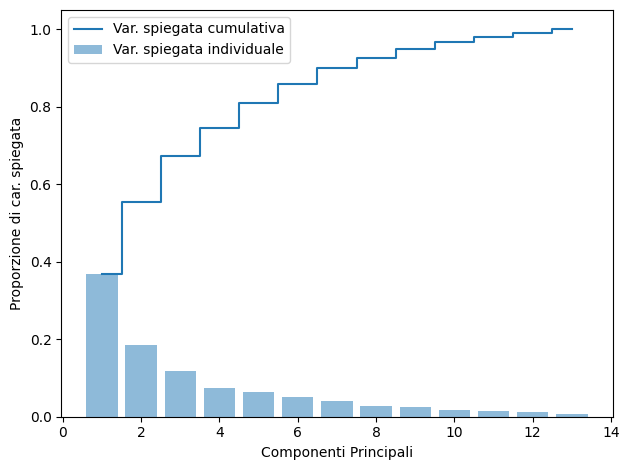

In [10]:
import matplotlib.pyplot as plt

plt.bar(range(1, 14), var_exp, alpha=0.5, align='center', label='Var. spiegata individuale')
plt.step(range(1, 14), cum_var_exp, where='mid', label='Var. spiegata cumulativa')
plt.ylabel('Proporzione di car. spiegata')
plt.xlabel('Componenti Principali')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

## Trasformazione delle Feature

In [11]:
# Crea una lista di coppie (autovalore, autovettore)
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i])
               for i in range(len(eigen_vals))]

# Ordina le coppie per autovalori decrescenti
eigen_pairs.sort(key=lambda k: k[0], reverse=True)

In [12]:
w = np.hstack((eigen_pairs[0][1][:, np.newaxis],
               eigen_pairs[1][1][:, np.newaxis]))
print('Matrice W:\n', w)

Matrice W:
 [[-0.13724218  0.50303478]
 [ 0.24724326  0.16487119]
 [-0.02545159  0.24456476]
 [ 0.20694508 -0.11352904]
 [-0.15436582  0.28974518]
 [-0.39376952  0.05080104]
 [-0.41735106 -0.02287338]
 [ 0.30572896  0.09048885]
 [-0.30668347  0.00835233]
 [ 0.07554066  0.54977581]
 [-0.32613263 -0.20716433]
 [-0.36861022 -0.24902536]
 [-0.29669651  0.38022942]]


**Nota**

A seconda della versione di NumPy e LAPACK in uso, <br>
si potrebbe avere una $W$ con segni cambiati
+ non costituisce un vero problema: 
    * se $v$ autovettore di $\Sigma$, i.e. $\Sigma v = \lambda v$, allora<br> anche $-v$ autovettore con autovalore $\lambda$, essendo $$\Sigma \cdot (-v) = -\Sigma v = -\lambda v = \lambda \cdot (-v)$$

**Esempio** | proiezione della prima istanza del training set:

In [13]:
X_train_std[0].dot(w)

array([2.38299011, 0.45458499])

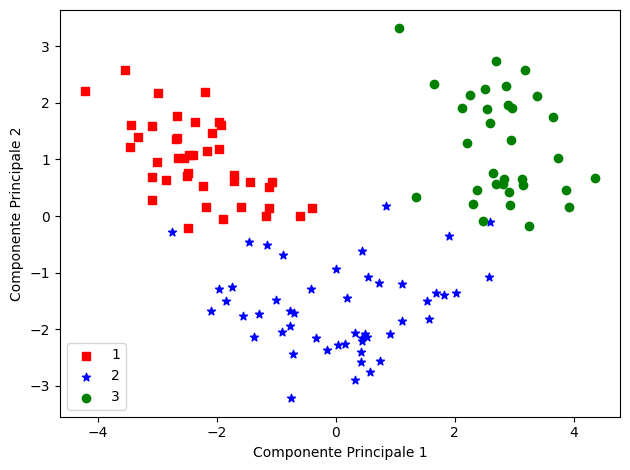

In [14]:
X_train_pca = X_train_std.dot(w)
colors = ['r', 'b', 'g']
markers = ['s', '*', 'o']

for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train == l, 0], X_train_pca[y_train == l, 1], 
                c=c, label=l, marker=m)

plt.xlabel('Componente Principale 1')
plt.ylabel('Componente Principale 2')
plt.legend(loc='lower left')
plt.tight_layout()

## PCA in `scikit-learn`

**NOTA**

Si mostra come replicare in scikit-learn (cfr documentazione) i risultati ottenuti con l'implementazione vista nella sezione precedente

In [15]:
from sklearn.decomposition import PCA

pca = PCA()
X_train_pca = pca.fit_transform(X_train_std)
pca.explained_variance_ratio_

array([0.36951469, 0.18434927, 0.11815159, 0.07334252, 0.06422108,
       0.05051724, 0.03954654, 0.02643918, 0.02389319, 0.01629614,
       0.01380021, 0.01172226, 0.00820609])

Text(0.5, 0, 'Componenti Principali')

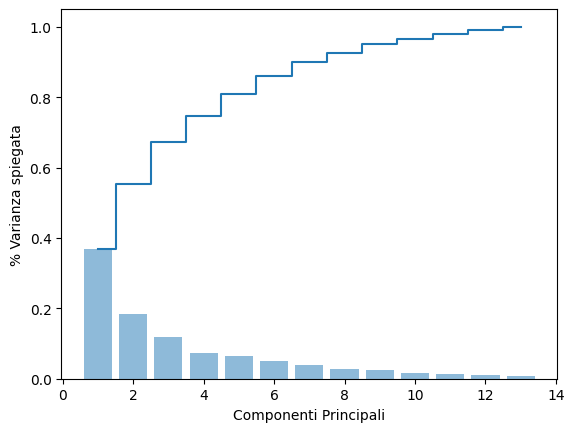

In [16]:
plt.bar(range(1, 14), pca.explained_variance_ratio_, alpha=0.5, align='center')
plt.step(range(1, 14), np.cumsum(pca.explained_variance_ratio_), where='mid')
plt.ylabel('% Varianza spiegata')
plt.xlabel('Componenti Principali')

In [17]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

Text(0, 0.5, 'Componente Principale 2')

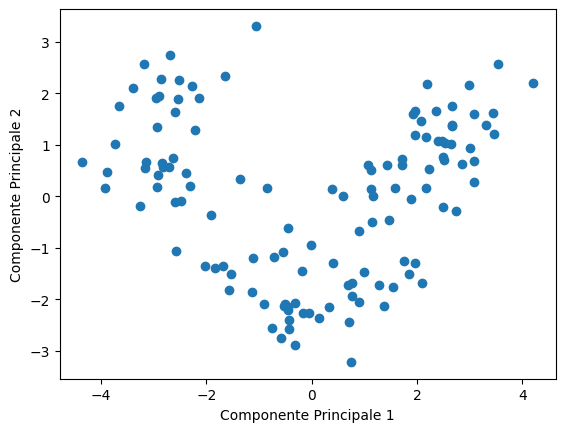

In [18]:
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1])
plt.xlabel('Componente Principale 1')
plt.ylabel('Componente Principale 2')

In [19]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', '*', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution), 
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot examples by class
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1], 
                    alpha=0.6, color=cmap(idx), edgecolor='black', 
                    marker=markers[idx], label=cl)

funzione vista in precedenza

<br>

**Esercizio**: usare la nuova [`sklearn.inspection.DecisionBoundaryDisplay`](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.DecisionBoundaryDisplay.html#)

Addestramento di un classificatore Naive Bayes (classe [GaussianNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html)) <br>usando le prime `2` componenti principali:

In [20]:
from sklearn.naive_bayes import GaussianNB

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

clf = GaussianNB().fit(X_train_pca, y_train)

training

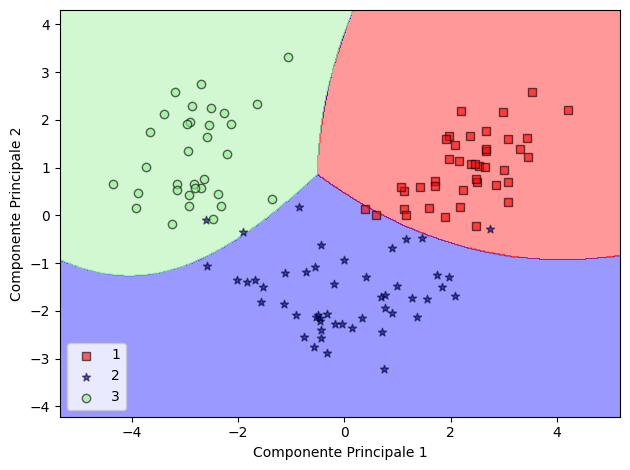

In [21]:
plot_decision_regions(X_train_pca, y_train, classifier=clf)
plt.xlabel('Componente Principale 1')
plt.ylabel('Componente Principale 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

test

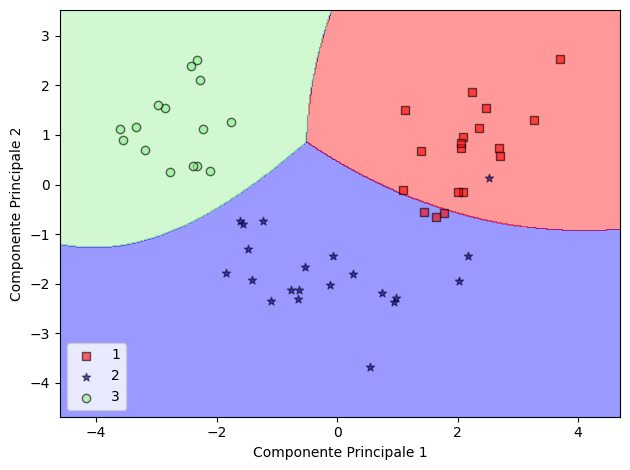

In [22]:
plot_decision_regions(X_test_pca, y_test, classifier=clf)
plt.xlabel('Componente Principale 1')
plt.ylabel('Componente Principale 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

Quote di varianza $\lambda_i$:

In [23]:
pca = PCA(n_components=None)
X_train_pca = pca.fit_transform(X_train_std)
pca.explained_variance_ratio_

array([0.36951469, 0.18434927, 0.11815159, 0.07334252, 0.06422108,
       0.05051724, 0.03954654, 0.02643918, 0.02389319, 0.01629614,
       0.01380021, 0.01172226, 0.00820609])

### Esercizio

+ Confrontare le prestazioni (accuratezza) di `GaussianNB` e altri classificatori-base di sklearn, come `RidgeClassifier`
    - in seguito anche [`GaussianMixture`](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html)
+ Confrontare regressori ottenuti senza e con PCA

# Compressione Dati Supervisionata tramite LDA

## PCA vs LDA

<img src='https://raw.githubusercontent.com/rasbt/python-machine-learning-book-3rd-edition/master/ch05/images/05_06.png' width=400> 

## Funzionamento Interno della LDA

## Calcolo delle Matrici di Scatter

Calcolo dei vettori *media campionaria* per classe:

In [24]:
np.set_printoptions(precision=4)

mean_vecs = []
for label in range(1, 4):
    mean_vecs.append(np.mean(X_train_std[y_train == label], axis=0))
    print('m%s: %s\n' % (label, mean_vecs[label - 1]))

m1: [ 0.9066 -0.3497  0.3201 -0.7189  0.5056  0.8807  0.9589 -0.5516  0.5416
  0.2338  0.5897  0.6563  1.2075]

m2: [-0.8749 -0.2848 -0.3735  0.3157 -0.3848 -0.0433  0.0635 -0.0946  0.0703
 -0.8286  0.3144  0.3608 -0.7253]

m3: [ 0.1992  0.866   0.1682  0.4148 -0.0451 -1.0286 -1.2876  0.8287 -0.7795
  0.9649 -1.209  -1.3622 -0.4013]



Calcolo della matrice di scatter _Within-class_ $\mathbf{S}_W$:

In [25]:
d = 13 # number of features
S_W = np.zeros((d, d))
for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.zeros((d, d))  # scatter matrix for each class
    for row in X_train_std[y_train == label]:
        row, mv = row.reshape(d, 1), mv.reshape(d, 1)  # make column vectors
        class_scatter += (row - mv).dot((row - mv).T)
    S_W += class_scatter                          # sum class scatter matrices

print('Within-class scatter matrix: %sx%s' % (S_W.shape[0], S_W.shape[1]))

Within-class scatter matrix: 13x13


*Miglioramento*: essendo le classi non equamente distribuite

In [26]:
print('Distribuzione delle etichette delle classi: %s' 
      % np.bincount(y_train)[1:])

Distribuzione delle etichette delle classi: [41 50 33]


+ le matrici di scatter per classe vanno riscalate prima di essere sommate per ottenere   $\mathbf{S}_W$
    + come per la matrice di covarianza che ne rappresenta una versione normalizzata, dividendo per il numero di es. nelle varie classi

In [27]:
d = 13  # numero di feature
S_W = np.zeros((d, d))
for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.cov(X_train_std[y_train == label].T)
    S_W += class_scatter
print('Within-class scatter matrix riscalata: %sx%s' % (S_W.shape[0],
                                                     S_W.shape[1]))

Within-class scatter matrix riscalata: 13x13


Calcolo della matrice di scatter _Between-class_ $\mathbf{S}_B$:

In [28]:
mean_overall = np.mean(X_train_std, axis=0)
d = 13  # numero di feature
S_B = np.zeros((d, d))
for i, mean_vec in enumerate(mean_vecs):
    n = X_train_std[y_train == i + 1, :].shape[0]
    mean_vec = mean_vec.reshape(d, 1)  # crea vettore-colonna
    mean_overall = mean_overall.reshape(d, 1)  # crea vettore-colonna
    S_B += n * (mean_vec - mean_overall).dot((mean_vec - mean_overall).T)

print('Between-class scatter matrix: %sx%s' % (S_B.shape[0], S_B.shape[1]))

Between-class scatter matrix: 13x13


## Selezione dei Discriminanti Lineari <br> per il Nuovo Sottospazio di Feature

Soluzione del problema di decomposizione generale per la matrice $\mathbf{S}_W^{-1}\mathbf{S}_B$:

In [29]:
eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

**Nota**:
    
Si è usato ancora [`numpy.linalg.eig`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.eig.html) 

Alternativa migliore: [`numpy.linalg.eigh`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.eigh.html) 


Ordinamento degli autovettori nell'ordine discendente degli autovalori:

In [30]:
# crea una lista di coppie (autovalore, autovettore) 
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]

# ordina le coppie in modo discendente
eigen_pairs = sorted(eigen_pairs, key=lambda k: k[0], reverse=True)

# conferma visuale che la lista sia correttamente ordinata per autovalori decrescenti
print('Autovalori in ordine discedente:\n')
for eigen_val in eigen_pairs:
    print(eigen_val[0])

Autovalori in ordine discedente:

349.61780890599397
172.76152218979382
3.158767453716165e-14
3.158767453716165e-14
2.143533148921218e-14
2.0710878131274385e-14
2.0674370524273945e-14
2.0674370524273945e-14
1.451265995204774e-14
1.451265995204774e-14
3.276640874343733e-15
5.531632407509499e-16
0.0


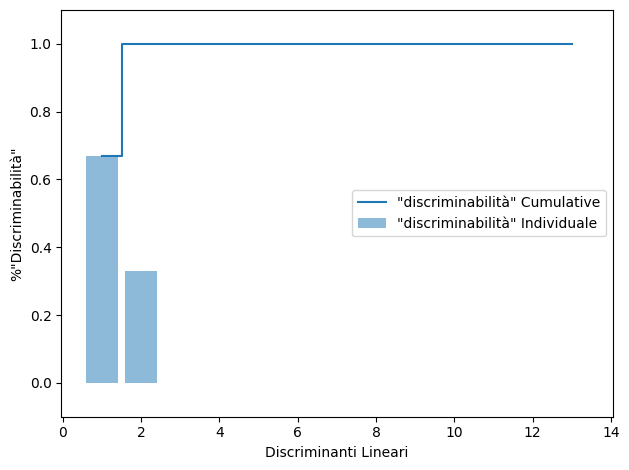

In [31]:
tot = sum(eigen_vals.real)
discr = [(i / tot) for i in sorted(eigen_vals.real, reverse=True)]
cum_discr = np.cumsum(discr)

plt.bar(range(1, 14), discr, alpha=0.5, align='center', label='"discriminabilità" Individuale')
plt.step(range(1, 14), cum_discr, where='mid', label='"discriminabilità" Cumulative')
plt.ylabel('%"Discriminabilità"')
plt.xlabel('Discriminanti Lineari')
plt.ylim([-0.1, 1.1])
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [32]:
w = np.hstack((eigen_pairs[0][1][:, np.newaxis].real,
              eigen_pairs[1][1][:, np.newaxis].real))
print('Matrice W:\n', w)

Matrice W:
 [[-0.1481 -0.4092]
 [ 0.0908 -0.1577]
 [-0.0168 -0.3537]
 [ 0.1484  0.3223]
 [-0.0163 -0.0817]
 [ 0.1913  0.0842]
 [-0.7338  0.2823]
 [-0.075  -0.0102]
 [ 0.0018  0.0907]
 [ 0.294  -0.2152]
 [-0.0328  0.2747]
 [-0.3547 -0.0124]
 [-0.3915 -0.5958]]


## Proiettare gli Esempi sul Nuovo Spazio di Feature

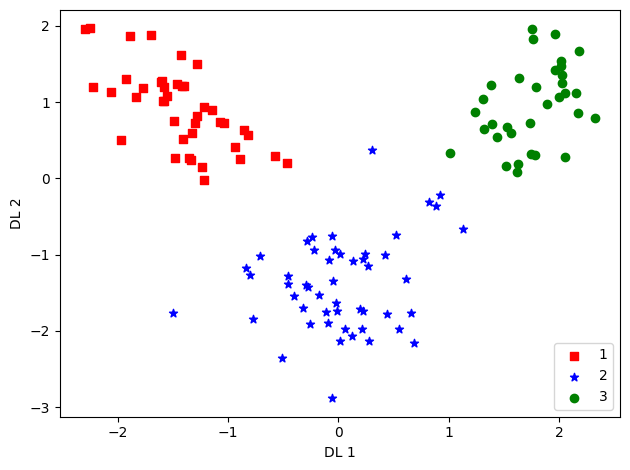

In [33]:
X_train_lda = X_train_std.dot(w)
colors = ['r', 'b', 'g']
markers = ['s', '*', 'o']

for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_lda[y_train == l, 0], X_train_lda[y_train == l, 1] * (-1),
                c=c, label=l, marker=m)

plt.xlabel('DL 1')
plt.ylabel('DL 2')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

## LDA via `scikit-learn`

In [34]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components=2)
X_train_lda = lda.fit_transform(X_train_std, y_train)

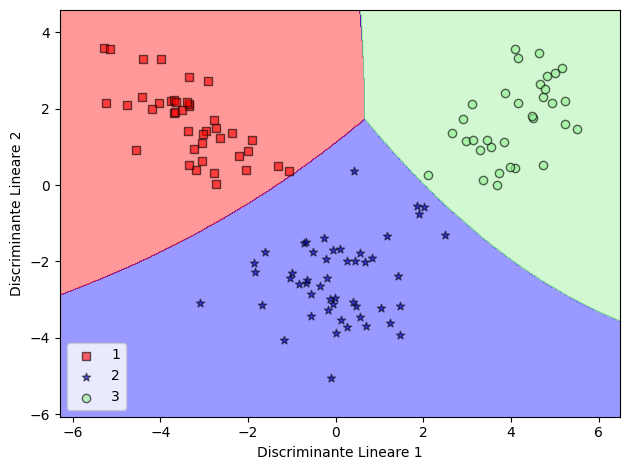

In [35]:
clf2 = GaussianNB().fit(X_train_lda, y_train)

plot_decision_regions(X_train_lda, y_train, classifier=clf2)
plt.xlabel('Discriminante Lineare 1')
plt.ylabel('Discriminante Lineare 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

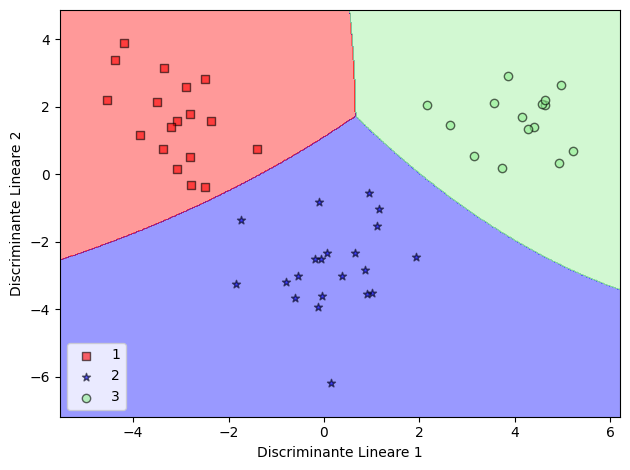

In [36]:
X_test_lda = lda.transform(X_test_std)

plot_decision_regions(X_test_lda, y_test, classifier=clf2)
plt.xlabel('Discriminante Lineare 1')
plt.ylabel('Discriminante Lineare 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

## Manifold Learning

- [`sklearn.manifold.MDS`](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.MDS.html)
- [`sklearn.manifold.Isomap`](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.Isomap.html)
- [`sklearn.manifold.LocallyLinearEmbedding`](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.LocallyLinearEmbedding.html)
- [`sklearn.manifold.SpectralEmbedding`](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.SpectralEmbedding.html)
- [`sklearn.manifold.TSNE`](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)



cfr. esempi nella doc. `scikit-learn`

1. [*cifre scritte a mano*](https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html) 
2. [*curva a S*](https://scikit-learn.org/stable/auto_examples/manifold/plot_compare_methods.html)




### Altri Modelli (supervisionati e non)

- [`sklearn.neighbors.NeighborhoodComponentsAnalysis`](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.SpectralEmbedding.html) 
- [`sklearn.random_projection.SparseRandomProjection`](https://scikit-learn.org/stable/modules/generated/sklearn.random_projection.SparseRandomProjection.html)
- [`sklearn.random_projection.GaussianRandomProjection`](https://scikit-learn.org/stable/modules/generated/sklearn.random_projection.GaussianRandomProjection.html)
- [`sklearn.decomposition.TruncatedSVD`](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html)
- [`sklearn.discriminant_analysis.LinearDiscriminantAnalysis`](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html)
- [`sklearn.ensemble import RandomTreesEmbedding`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomTreesEmbedding.html)



#### Esempio: tagli di una sfera

standard: 0.49 sec
ltsa: 1.1 sec
hessian: 0.77 sec
modified: 1.5 sec
ISO: 0.48 sec
MDS: 1.7 sec
Spectral Embedding: 0.065 sec
t-SNE: 2.2 sec


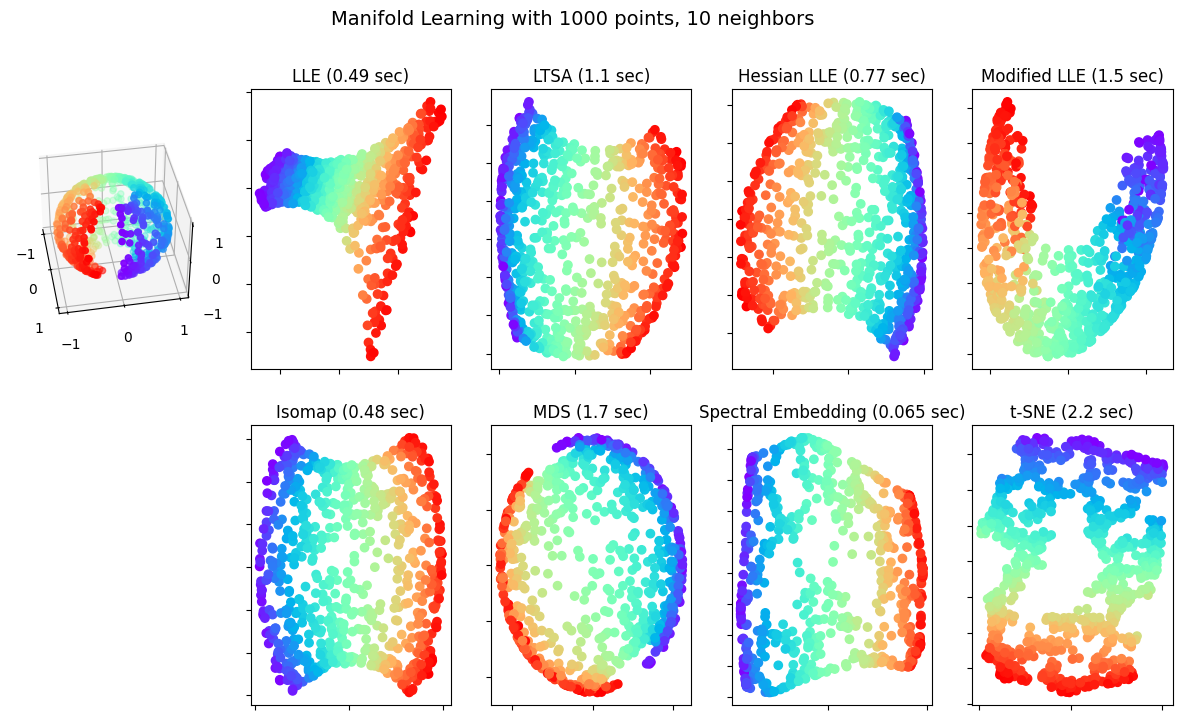

In [37]:
from time import time

import matplotlib.pyplot as plt

# Unused but required import for doing 3d projections with matplotlib < 3.2
import mpl_toolkits.mplot3d  # noqa: F401
import numpy as np
from matplotlib.ticker import NullFormatter

from sklearn import manifold
from sklearn.utils import check_random_state

# Variables for manifold learning.
n_neighbors = 10
n_samples = 1000

# Create our sphere.
random_state = check_random_state(0)
p = random_state.rand(n_samples) * (2 * np.pi - 0.55)
t = random_state.rand(n_samples) * np.pi

# Sever the poles from the sphere.
indices = (t < (np.pi - (np.pi / 8))) & (t > ((np.pi / 8)))
colors = p[indices]
x, y, z = (
    np.sin(t[indices]) * np.cos(p[indices]),
    np.sin(t[indices]) * np.sin(p[indices]),
    np.cos(t[indices]),
)

# Plot our dataset.
fig = plt.figure(figsize=(15, 8))
plt.suptitle(
    "Manifold Learning with %i points, %i neighbors" % (1000, n_neighbors), fontsize=14
)

ax = fig.add_subplot(251, projection="3d")
ax.scatter(x, y, z, c=p[indices], cmap=plt.cm.rainbow)
ax.view_init(40, -10)

sphere_data = np.array([x, y, z]).T

# Perform Locally Linear Embedding Manifold learning
methods = ["standard", "ltsa", "hessian", "modified"]
labels = ["LLE", "LTSA", "Hessian LLE", "Modified LLE"]

for i, method in enumerate(methods):
    t0 = time()
    trans_data = (
        manifold.LocallyLinearEmbedding(
            n_neighbors=n_neighbors, n_components=2, method=method, random_state=42
        )
        .fit_transform(sphere_data)
        .T
    )
    t1 = time()
    print("%s: %.2g sec" % (methods[i], t1 - t0))

    ax = fig.add_subplot(252 + i)
    plt.scatter(trans_data[0], trans_data[1], c=colors, cmap=plt.cm.rainbow)
    plt.title("%s (%.2g sec)" % (labels[i], t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis("tight")

# Perform Isomap Manifold learning.
t0 = time()
trans_data = (
    manifold.Isomap(n_neighbors=n_neighbors, n_components=2)
    .fit_transform(sphere_data)
    .T
)
t1 = time()
print("%s: %.2g sec" % ("ISO", t1 - t0))

ax = fig.add_subplot(257)
plt.scatter(trans_data[0], trans_data[1], c=colors, cmap=plt.cm.rainbow)
plt.title("%s (%.2g sec)" % ("Isomap", t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis("tight")

# Perform Multi-dimensional scaling.
t0 = time()
mds = manifold.MDS(2, max_iter=100, n_init=1, random_state=42)
trans_data = mds.fit_transform(sphere_data).T
t1 = time()
print("MDS: %.2g sec" % (t1 - t0))

ax = fig.add_subplot(258)
plt.scatter(trans_data[0], trans_data[1], c=colors, cmap=plt.cm.rainbow)
plt.title("MDS (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis("tight")

# Perform Spectral Embedding.
t0 = time()
se = manifold.SpectralEmbedding(
    n_components=2, n_neighbors=n_neighbors, random_state=42
)
trans_data = se.fit_transform(sphere_data).T
t1 = time()
print("Spectral Embedding: %.2g sec" % (t1 - t0))

ax = fig.add_subplot(259)
plt.scatter(trans_data[0], trans_data[1], c=colors, cmap=plt.cm.rainbow)
plt.title("Spectral Embedding (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis("tight")

# Perform t-distributed stochastic neighbor embedding.
t0 = time()
tsne = manifold.TSNE(n_components=2, random_state=0)
trans_data = tsne.fit_transform(sphere_data).T
t1 = time()
print("t-SNE: %.2g sec" % (t1 - t0))

ax = fig.add_subplot(2, 5, 10)
plt.scatter(trans_data[0], trans_data[1], c=colors, cmap=plt.cm.rainbow)
plt.title("t-SNE (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis("tight")

plt.show()

#### Esempio
kNN preceduto da PCA, LDA, NCA: [doc](https://scikit-learn.org/stable/auto_examples/neighbors/plot_nca_dim_reduction.html#sphx-glr-auto-examples-neighbors-plot-nca-dim-reduction-py)

# Uso della Kernel PCA per Mappature non Lineari

<img src='https://raw.githubusercontent.com/rasbt/python-machine-learning-book-3rd-edition/master/ch05/images/05_11.png'>

## Implementare la Kernel PCA in Python

In [38]:
from scipy.spatial.distance import pdist, squareform
from scipy.linalg import eigh
import numpy as np


from distutils.version import LooseVersion as Version
from scipy import __version__ as scipy_version


if scipy_version >= Version('1.4.1'):
    from numpy import exp
else:
    from scipy import exp

def rbf_kernel_pca(X, gamma, n_components):
    """
    RBF kernel PCA implementation.

    Parameters
    ------------
    X: {NumPy ndarray}, shape = [n_examples, n_features]
        
    gamma: float
      Tuning parameter of the RBF kernel
        
    n_components: int
      Number of principal components to return

    Returns
    ------------
     X_pc: {NumPy ndarray}, shape = [n_examples, k_features]
       Projected dataset   

    """
    # Calculate pairwise squared Euclidean distances
    # in the MxN dimensional dataset.
    sq_dists = pdist(X, 'sqeuclidean')

    # Convert pairwise distances into a square matrix.
    mat_sq_dists = squareform(sq_dists)

    # Compute the symmetric kernel matrix.
    K = exp(-gamma * mat_sq_dists)

    # Center the kernel matrix.
    N = K.shape[0]
    one_n = np.ones((N, N)) / N
    K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)

    # Obtaining eigenpairs from the centered kernel matrix
    # scipy.linalg.eigh returns them in ascending order
    eigvals, eigvecs = eigh(K)
    eigvals, eigvecs = eigvals[::-1], eigvecs[:, ::-1]

    # Collect the top k eigenvectors (projected examples)
    X_pc = np.column_stack([eigvecs[:, i]
                            for i in range(n_components)])

    return X_pc

/tmp/ipykernel_10697/3126337537.py:10: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if scipy_version >= Version('1.4.1'):


### Esempio 1: Separare Dati _half-moon_

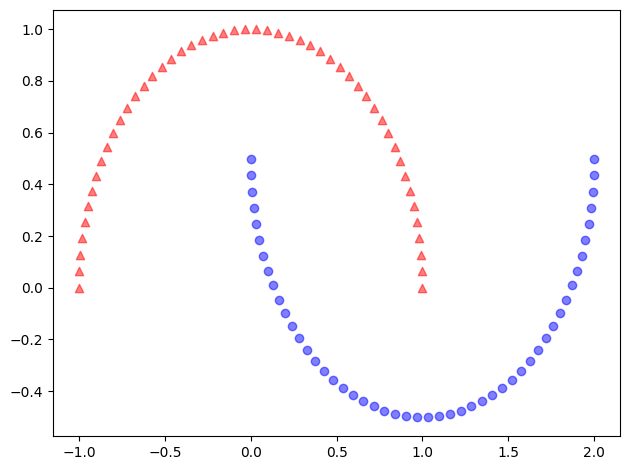

In [39]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=100, random_state=123)

plt.scatter(X[y == 0, 0], X[y == 0, 1], color='red', marker='^', alpha=0.5)
plt.scatter(X[y == 1, 0], X[y == 1, 1], color='blue', marker='o', alpha=0.5)

plt.tight_layout()
plt.show()

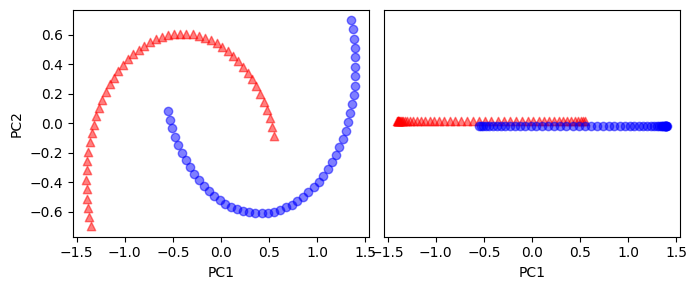

In [40]:
from sklearn.decomposition import PCA

scikit_pca = PCA(n_components=2)
X_spca = scikit_pca.fit_transform(X)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))

ax[0].scatter(X_spca[y == 0, 0], X_spca[y == 0, 1], color='red', marker='^', alpha=0.5)
ax[0].scatter(X_spca[y == 1, 0], X_spca[y == 1, 1], color='blue', marker='o', alpha=0.5)

ax[1].scatter(X_spca[y == 0, 0], np.zeros((50, 1)) + 0.02, color='red', marker='^', alpha=0.5)
ax[1].scatter(X_spca[y == 1, 0], np.zeros((50, 1)) - 0.02, color='blue', marker='o', alpha=0.5)

ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')

plt.tight_layout()
plt.show()

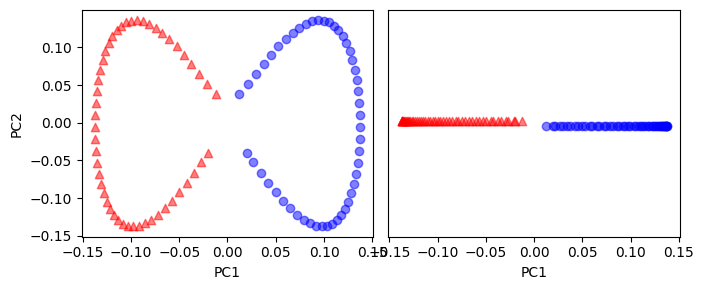

In [41]:
X_kpca = rbf_kernel_pca(X, gamma=15, n_components=2)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))
ax[0].scatter(X_kpca[y==0, 0], X_kpca[y==0, 1], color='red', marker='^', alpha=0.5)
ax[0].scatter(X_kpca[y==1, 0], X_kpca[y==1, 1], color='blue', marker='o', alpha=0.5)

ax[1].scatter(X_kpca[y==0, 0], np.zeros((50, 1))+0.02, color='red', marker='^', alpha=0.5)
ax[1].scatter(X_kpca[y==1, 0], np.zeros((50, 1))-0.02, color='blue', marker='o', alpha=0.5)

ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')

plt.tight_layout()
plt.show()

### Esempio 2: Separare Cerchi Concentrici

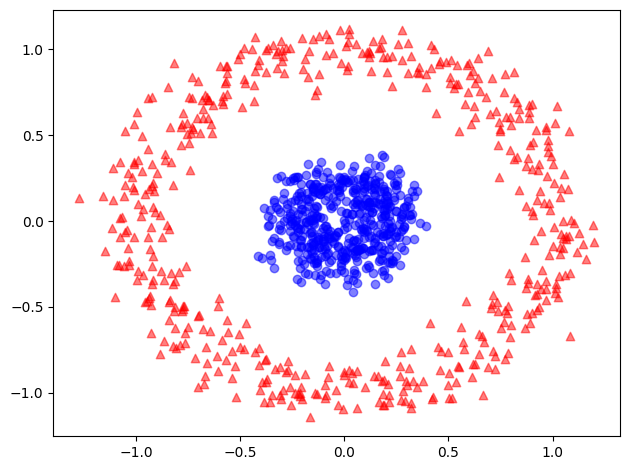

In [42]:
from sklearn.datasets import make_circles

X, y = make_circles(n_samples=1000, random_state=123, noise=0.1, factor=0.2)

plt.scatter(X[y == 0, 0], X[y == 0, 1], color='red', marker='^', alpha=0.5)
plt.scatter(X[y == 1, 0], X[y == 1, 1], color='blue', marker='o', alpha=0.5)
plt.tight_layout()

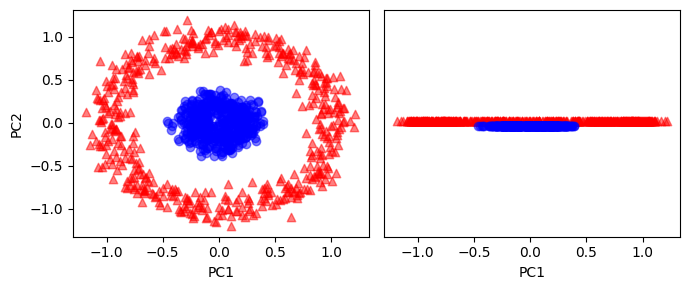

In [43]:
scikit_pca = PCA(n_components=2)
X_spca = scikit_pca.fit_transform(X)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))

ax[0].scatter(X_spca[y == 0, 0], X_spca[y == 0, 1], color='red', marker='^', alpha=0.5)
ax[0].scatter(X_spca[y == 1, 0], X_spca[y == 1, 1], color='blue', marker='o', alpha=0.5)

ax[1].scatter(X_spca[y == 0, 0], np.zeros((500, 1)) + 0.02, color='red', marker='^', alpha=0.5)
ax[1].scatter(X_spca[y == 1, 0], np.zeros((500, 1)) - 0.02, color='blue', marker='o', alpha=0.5)

ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')
plt.tight_layout()

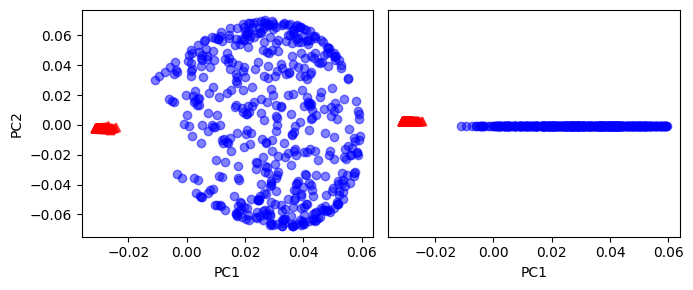

In [44]:
X_kpca = rbf_kernel_pca(X, gamma=15, n_components=2)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))
ax[0].scatter(X_kpca[y == 0, 0], X_kpca[y == 0, 1], color='red', marker='^', alpha=0.5)
ax[0].scatter(X_kpca[y == 1, 0], X_kpca[y == 1, 1], color='blue', marker='o', alpha=0.5)

ax[1].scatter(X_kpca[y == 0, 0], np.zeros((500, 1)) + 0.02, color='red', marker='^', alpha=0.5)
ax[1].scatter(X_kpca[y == 1, 0], np.zeros((500, 1)) - 0.02, color='blue', marker='o', alpha=0.5)

ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')
plt.tight_layout()


## Proiezione dei Nuovi Dati

In [45]:
from scipy.spatial.distance import pdist, squareform
from numpy import exp
from scipy.linalg import eigh
import numpy as np

def rbf_kernel_pca(X, gamma, n_components):

    # Calculate pairwise squared Euclidean distances
    # in the MxN dimensional dataset.
    sq_dists = pdist(X, 'sqeuclidean')

    # Convert pairwise distances into a square matrix.
    mat_sq_dists = squareform(sq_dists)

    # Compute the symmetric kernel matrix.
    K = exp(-gamma * mat_sq_dists)

    # Center the kernel matrix.
    N = K.shape[0]
    one_n = np.ones((N, N)) / N
    K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)

    # Obtaining eigenpairs from the centered kernel matrix
    # scipy.linalg.eigh returns them in ascending order
    eigvals, eigvecs = eigh(K)
    eigvals, eigvecs = eigvals[::-1], eigvecs[:, ::-1]

    # Collect the top k eigenvectors (projected examples)
    alphas = np.column_stack([eigvecs[:, i]
                              for i in range(n_components)])

    # Collect the corresponding eigenvalues
    lambdas = [eigvals[i] for i in range(n_components)]

    return alphas, lambdas

In [46]:
X, y = make_moons(n_samples=100, random_state=123)
alphas, lambdas = rbf_kernel_pca(X, gamma=15, n_components=1)

In [47]:
x_new = X[25]
x_new

array([1.8713, 0.0093])

In [48]:
x_proj = alphas[25] # proiezione originaria
x_proj

array([0.0788])

In [49]:
def project_x(x_new, X, gamma, alphas, lambdas):
    pair_dist = np.array([np.sum((x_new - row)**2) for row in X])
    k = np.exp(-gamma * pair_dist)
    return k.dot(alphas / lambdas)

# proiezionedel"nuovo" punto
x_reproj = project_x(x_new, X, gamma=15, alphas=alphas, lambdas=lambdas)
x_reproj 

array([0.0788])

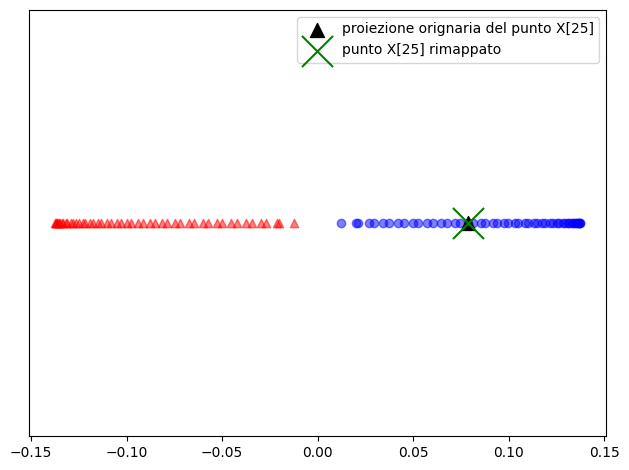

In [50]:
plt.scatter(alphas[y == 0, 0], np.zeros((50)),
            color='red', marker='^', alpha=0.5)
plt.scatter(alphas[y == 1, 0], np.zeros((50)),
            color='blue', marker='o', alpha=0.5)
plt.scatter(x_proj, 0, color='black',
            label='proiezione orignaria del punto X[25]', marker='^', s=100)
plt.scatter(x_reproj, 0, color='green',
            label='punto X[25] rimappato', marker='x', s=500)
plt.yticks([], [])
plt.legend(scatterpoints=1)

plt.tight_layout()
plt.show()

## Kernel PCA in scikit-learn

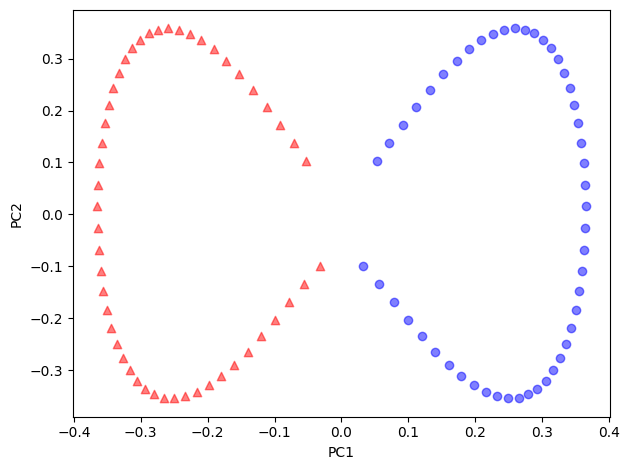

In [51]:
from sklearn.decomposition import KernelPCA

X, y = make_moons(n_samples=100, random_state=123)
scikit_kpca = KernelPCA(n_components=2, kernel='rbf', gamma=15)
X_skernpca = scikit_kpca.fit_transform(X)

plt.scatter(X_skernpca[y == 0, 0], X_skernpca[y == 0, 1], color='red', marker='^', alpha=0.5)
plt.scatter(X_skernpca[y == 1, 0], X_skernpca[y == 1, 1], color='blue', marker='o', alpha=0.5)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.tight_layout()